# Hospitality Heuristics: Reviewing Revenues

---

- Data: hotel datasets from capstone
- Goal: Design/develop on-demand report generation for common metrics
- Breakdown:
    - Calculate daily revenue(s)
    - Calculate daily occupancy
        - By room type
        - By rate segmentation
        - By rate amount (e.g., quartiles, etc.)

---

# Package Imports

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

import seaborn as sns

import shap

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import xgboost as xgb

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)

%matplotlib inline

# Reading Datasets

* Need to import data separately
* Add unique identifier for each (IsCity?)
* Concatenate into single dataframe

In [2]:
data_path_resort = './data/Resort_Data.xlsx'
data_path_city = './data/City_Data.xlsx'

In [3]:
resort_df = pd.read_excel(data_path_resort)
resort_df['IsResort'] = 1
# resort_df

city_df = pd.read_excel(data_path_city)
city_df['IsResort'] = 0
# city_df

full_data = pd.concat([resort_df, city_df], axis = 0)
full_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsResort
0,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,0
79326,0,102,2017,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,0
79327,0,34,2017,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,0
79328,0,109,2017,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,0


# Review Full Dataset

**What will I reliably know?**

* Need to filter for features guaranteed to be on reservations
* Could build other features using other models (e.g., regression/classifications)

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 0 to 79329
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   IsCanceled                   119390 non-null  int64         
 1   LeadTime                     119390 non-null  int64         
 2   ArrivalDateYear              119390 non-null  int64         
 3   ArrivalDateMonth             119390 non-null  object        
 4   ArrivalDateWeekNumber        119390 non-null  int64         
 5   ArrivalDateDayOfMonth        119390 non-null  int64         
 6   StaysInWeekendNights         119390 non-null  int64         
 7   StaysInWeekNights            119390 non-null  int64         
 8   Adults                       119390 non-null  int64         
 9   Children                     119386 non-null  float64       
 10  Babies                       119390 non-null  int64         
 11  Meal                         119

## Feature Engineering


Some features are good as-is, while others have options for feature engineering

simple_features: 'LeadTime', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekNights',
                   'StaysInWeekendNights','ADR', 'CustomerType','MarketSegment', 'ReservedRoomType',
                   'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled',
                   'BookingChanges', 'TotalOfSpecialRequests', 'IsResort'

dow_arrival: 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth'

dow_departure: 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth', 'StaysInWeekNights',
                   'StaysInWeekendNights'

In [5]:
# full_data['StaysInWeekNights'].value_counts(ascending = False, normalize = True, dropna = False)
full_data['StaysInWeekNights'].describe()

count   119,390.00
mean          2.50
std           1.91
min           0.00
25%           1.00
50%           2.00
75%           3.00
max          50.00
Name: StaysInWeekNights, dtype: float64

In [6]:
full_data[(full_data['StaysInWeekNights'] + full_data['StaysInWeekendNights']) == 0]['IsCanceled'].describe()

count   715.00
mean      0.05
std       0.22
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: IsCanceled, dtype: float64

In [7]:
full_data['ADR'].describe()

count   119,390.00
mean        101.83
std          50.54
min          -6.38
25%          69.29
50%          94.58
75%         126.00
max       5,400.00
Name: ADR, dtype: float64

In [8]:
# full_data[full_data['ADR'] != 0]['IsCanceled'].describe()
full_data[full_data['ADR'] != 0]['IsCanceled'].value_counts(normalize= True)

IsCanceled
0   0.63
1   0.37
Name: proportion, dtype: float64

# Feature Notes

* ADR, StaysInWeek/endNights features are too strongly indicative of whether or not a reservation is cancelled.
* Remove these features for now; may be useful in later modeling

In [9]:
# full_data[dow_arrival]

In [10]:
full_data['ArrivalDayofWeek'] = (pd.to_datetime(full_data['ArrivalDateYear'].astype(str)
                                             + "-" + full_data['ArrivalDateMonth']
                                             + "-" + full_data['ArrivalDateDayOfMonth']
                                             .astype(str))
                               .dt.dayofweek)
full_data['ArrivalDayofWeek']

0        2
1        2
2        2
3        2
4        2
        ..
79325    2
79326    3
79327    3
79328    3
79329    1
Name: ArrivalDayofWeek, Length: 119390, dtype: int32

In [11]:
full_data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsResort,ArrivalDayofWeek
0,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,2
1,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,2
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,2
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,2
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,2


# Selecting Features

I want to select a subset of reservation features that are independent of any temporal impact.

Several features (e.g., BookingChanges) will be too variable depending on the age of the reservation. I want to understand the likelihood of a cancellation separate from any variable features.

In [12]:
selected_features = ['LeadTime', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'ArrivalDayofWeek',
                     'ADR', 'CustomerType', 'MarketSegment', 'ReservedRoomType',
                     'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled',
                     'TotalOfSpecialRequests', 'IsResort']

selected_features

['LeadTime',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'ArrivalDayofWeek',
 'ADR',
 'CustomerType',
 'MarketSegment',
 'ReservedRoomType',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'TotalOfSpecialRequests',
 'IsResort']

In [13]:
data_subset = full_data[['IsCanceled', *selected_features]]
data_subset

,IsCanceled,LeadTime,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,ArrivalDayofWeek,ADR,CustomerType,MarketSegment,ReservedRoomType,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,TotalOfSpecialRequests,IsResort
0,0,342,27,1,2,0.00,Transient,Direct,C,0,0,0,0,1
1,0,737,27,1,2,0.00,Transient,Direct,C,0,0,0,0,1
2,0,7,27,1,2,75.00,Transient,Direct,A,0,0,0,0,1
3,0,13,27,1,2,75.00,Transient,Corporate,A,0,0,0,0,1
4,0,14,27,1,2,98.00,Transient,Online TA,A,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,35,30,2,96.14,Transient,Offline TA/TO,A,0,0,0,0,0
79326,0,102,35,31,3,225.43,Transient,Online TA,E,0,0,0,2,0
79327,0,34,35,31,3,157.71,Transient,Online TA,D,0,0,0,4,0
79328,0,109,35,31,3,104.40,Transient,Online TA,A,0,0,0,0,0


In [14]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 0 to 79329
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateWeekNumber        119390 non-null  int64  
 3   ArrivalDateDayOfMonth        119390 non-null  int64  
 4   ArrivalDayofWeek             119390 non-null  int32  
 5   ADR                          119390 non-null  float64
 6   CustomerType                 119390 non-null  object 
 7   MarketSegment                119390 non-null  object 
 8   ReservedRoomType             119390 non-null  object 
 9   IsRepeatedGuest              119390 non-null  int64  
 10  PreviousCancellations        119390 non-null  int64  
 11  PreviousBookingsNotCanceled  119390 non-null  int64  
 12  TotalOfSpecialRequests       119390 non-null  int64  
 13  IsRes

In [15]:
data_subset.describe(include = "number")

,IsCanceled,LeadTime,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,ArrivalDayofWeek,ADR,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,TotalOfSpecialRequests,IsResort
count,"119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00"
mean,0.37,104.01,27.17,15.80,3.00,101.83,0.03,0.09,0.14,0.57,0.34
std,0.48,106.86,13.61,8.78,1.95,50.54,0.18,0.84,1.50,0.79,0.47
min,0.00,0.00,1.00,1.00,0.00,-6.38,0.00,0.00,0.00,0.00,0.00
25%,0.00,18.00,16.00,8.00,1.00,69.29,0.00,0.00,0.00,0.00,0.00
50%,0.00,69.00,28.00,16.00,3.00,94.58,0.00,0.00,0.00,0.00,0.00
75%,1.00,160.00,38.00,23.00,5.00,126.00,0.00,0.00,0.00,1.00,1.00
max,1.00,737.00,53.00,31.00,6.00,"5,400.00",1.00,26.00,72.00,5.00,1.00


In [16]:
data_subset.describe(exclude = "number")

,CustomerType,MarketSegment,ReservedRoomType
count,119390,119390,119390
unique,4,8,10
top,Transient,Online TA,A
freq,89613,56477,85994


# Starting Modeling

In [17]:
def classy_report(model, X_train, y_train, X_test, y_test):
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("\n\n",classification_report(y_test, y_pred),"\n\n")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', normalize = "true")

## Train-Test Split

In [18]:
target = 'IsCanceled'

# Assuming 'df' is your DataFrame
X = data_subset.drop(columns = [target]).select_dtypes('number')
y = data_subset[target]   # Target variable

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 0 to 79329
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   LeadTime                     119390 non-null  int64  
 1   ArrivalDateWeekNumber        119390 non-null  int64  
 2   ArrivalDateDayOfMonth        119390 non-null  int64  
 3   ArrivalDayofWeek             119390 non-null  int32  
 4   ADR                          119390 non-null  float64
 5   IsRepeatedGuest              119390 non-null  int64  
 6   PreviousCancellations        119390 non-null  int64  
 7   PreviousBookingsNotCanceled  119390 non-null  int64  
 8   TotalOfSpecialRequests       119390 non-null  int64  
 9   IsResort                     119390 non-null  int64  
dtypes: float64(1), int32(1), int64(8)
memory usage: 9.6 MB


In [20]:
y.info()

<class 'pandas.core.series.Series'>
Index: 119390 entries, 0 to 79329
Series name: IsCanceled
Non-Null Count   Dtype
--------------   -----
119390 non-null  int64
dtypes: int64(1)
memory usage: 1.8 MB


In [21]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## XGBoost

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead




               precision    recall  f1-score   support

           0       0.81      0.90      0.85     18792
           1       0.79      0.63      0.70     11056

    accuracy                           0.80     29848
   macro avg       0.80      0.77      0.78     29848
weighted avg       0.80      0.80      0.80     29848
 




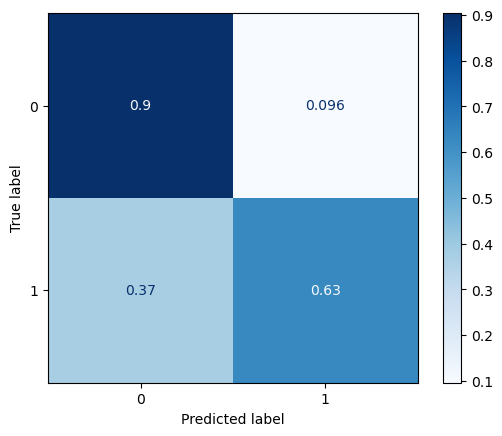

In [22]:
# Instantiate an XGBoost classifier
model = xgb.XGBClassifier(eval_metric='logloss')

## Generate predictions and classification reports
classy_report(model, X_train, y_train, X_test, y_test)

## HistGradientBoostingClassifier



               precision    recall  f1-score   support

           0       0.79      0.90      0.84     18792
           1       0.78      0.59      0.67     11056

    accuracy                           0.79     29848
   macro avg       0.79      0.75      0.76     29848
weighted avg       0.79      0.79      0.78     29848
 




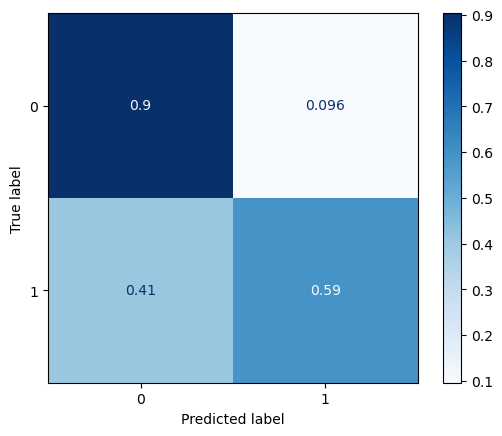

In [23]:
# Instantiate the classifier
classifier = HistGradientBoostingClassifier()

## Generate predictions and classification reports
classy_report(classifier, X_train, y_train, X_test, y_test)

# Imbalanced-Learn

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.




               precision    recall  f1-score   support

           0       0.86      0.84      0.85     18792
           1       0.74      0.77      0.76     11056

    accuracy                           0.82     29848
   macro avg       0.80      0.81      0.81     29848
weighted avg       0.82      0.82      0.82     29848
 




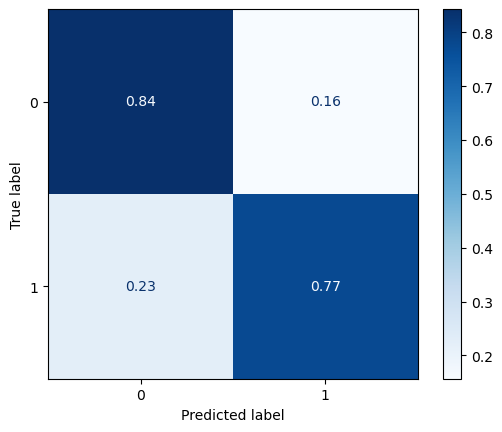

In [24]:
# Create the classifier
brf_classifier = BalancedRandomForestClassifier(random_state=42, sampling_strategy = 'all', replacement = 'True')

## Generate predictions and classification reports
classy_report(brf_classifier, X_train, y_train, X_test, y_test)

In [25]:
# Applying SMOTE to generate synthetic samples for the minority class
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# smote_enn = SMOTETomek(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X, y)


## RandomForestClassifier



               precision    recall  f1-score   support

           0       0.84      0.91      0.87     18792
           1       0.82      0.70      0.75     11056

    accuracy                           0.83     29848
   macro avg       0.83      0.80      0.81     29848
weighted avg       0.83      0.83      0.83     29848
 




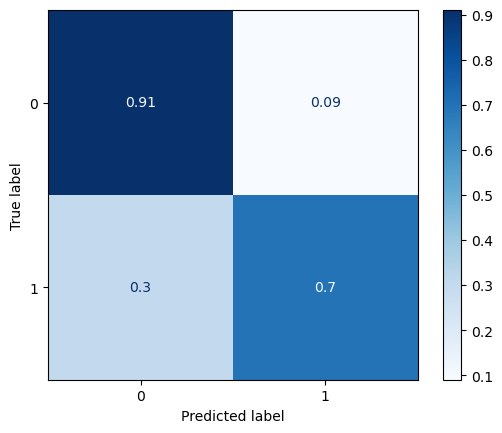

In [26]:
# Create a classifier
rfc_imb = RandomForestClassifier(random_state=42, n_jobs=-1)

## Generate predictions and classification reports
classy_report(rfc_imb, X_train, y_train, X_test, y_test)



               precision    recall  f1-score   support

           0       0.84      0.91      0.87     18792
           1       0.82      0.70      0.75     11056

    accuracy                           0.83     29848
   macro avg       0.83      0.80      0.81     29848
weighted avg       0.83      0.83      0.83     29848
 




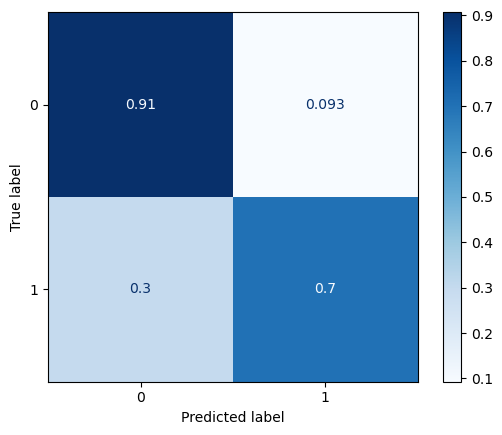

In [27]:
# Create a classifier
rfc_bal = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

## Generate predictions and classification reports
classy_report(rfc_bal, X_train, y_train, X_test, y_test)

## SMOTE-ing

In [28]:
## Applying SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



               precision    recall  f1-score   support

           0       0.85      0.87      0.86     18792
           1       0.77      0.74      0.76     11056

    accuracy                           0.82     29848
   macro avg       0.81      0.81      0.81     29848
weighted avg       0.82      0.82      0.82     29848
 




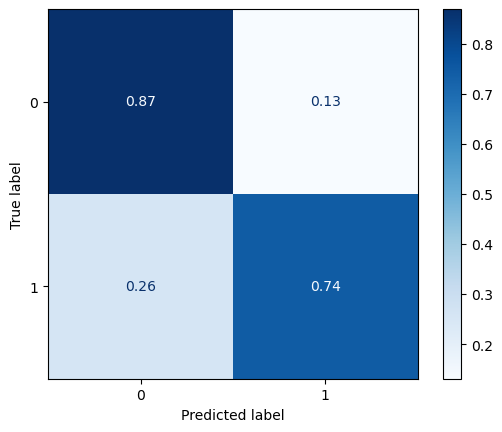

In [29]:
# Create a classifier
rfc_imb = RandomForestClassifier(random_state=42, n_jobs=-1)

## Generate predictions and classification reports
classy_report(rfc_imb, X_resampled, y_resampled, X_test, y_test)



               precision    recall  f1-score   support

           0       0.85      0.87      0.86     18792
           1       0.77      0.74      0.76     11056

    accuracy                           0.82     29848
   macro avg       0.81      0.81      0.81     29848
weighted avg       0.82      0.82      0.82     29848
 




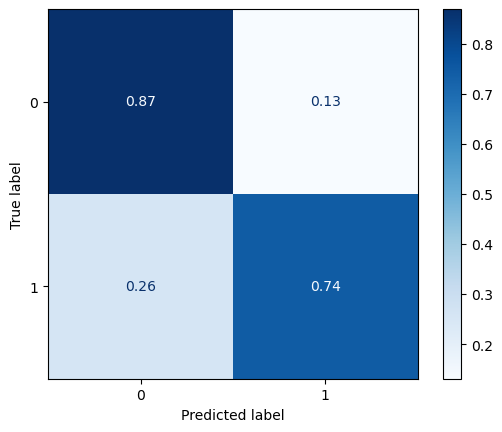

In [30]:
# Create a classifier
rfc_bal = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

## Generate predictions and classification reports
classy_report(rfc_imb, X_resampled, y_resampled, X_test, y_test)



               precision    recall  f1-score   support

           0       0.89      0.86      0.87     18792
           1       0.77      0.83      0.80     11056

    accuracy                           0.85     29848
   macro avg       0.83      0.84      0.84     29848
weighted avg       0.85      0.85      0.85     29848
 




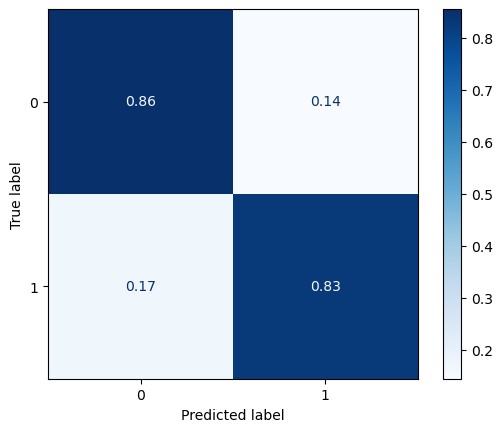

In [31]:
## Testing alternate SMOTE - SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Create a classifier
rfc_imb = RandomForestClassifier(random_state=42, n_jobs=-1)

## Generate predictions and classification reports
classy_report(rfc_imb, X_resampled, y_resampled, X_test, y_test)



               precision    recall  f1-score   support

           0       0.97      0.98      0.97     18792
           1       0.96      0.94      0.95     11056

    accuracy                           0.96     29848
   macro avg       0.96      0.96      0.96     29848
weighted avg       0.96      0.96      0.96     29848
 




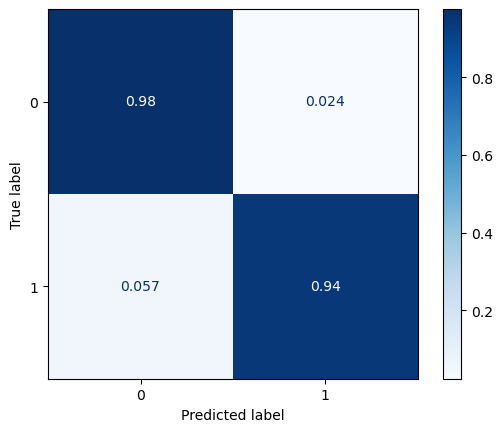

In [32]:
## Testing alternate SMOTE - SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Create a classifier
rfc_tomek = RandomForestClassifier(random_state=42, n_jobs=-1)

## Generate predictions and classification reports
classy_report(rfc_tomek, X_resampled, y_resampled, X_test, y_test)

In [33]:
# # Calculate permutation importance
# result = permutation_importance(rfc_tomek, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# # Get importances and feature names
# importances = result.importances_mean
# feature_names = X_test.columns

In [34]:
# # Sort the feature importances in descending order and select the top 5
# indices = np.argsort(importances)[::-1]
# top_indices = indices[:10]

# # Create a horizontal bar plot
# plt.figure(figsize=(10, 5))
# plt.title("Top 5 Permutation Importances")
# plt.barh(range(len(top_indices)), importances[top_indices], color='blue', align='center')
# plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
# plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
# plt.xlabel("Mean Decrease in Accuracy")
# plt.ylabel("Feature")
# plt.show()

In [35]:
# # Select a random subset of data for SHAP analysis
# subset = X_test.sample(n=100, random_state=42)  # Adjust n based on your dataset size
# explainer = shap.TreeExplainer(rfc_tomek)
# shap_values = explainer.shap_values(subset)

In [36]:
# # Select a random subset of data for SHAP analysis
# subset = X_test.sample(n=100, random_state=42)  # Adjust n based on your dataset size

# # Create a SHAP explainer
# explainer = shap.Explainer(rfc_tomek)

# # Compute SHAP values
# shap_values = explainer(X_test)

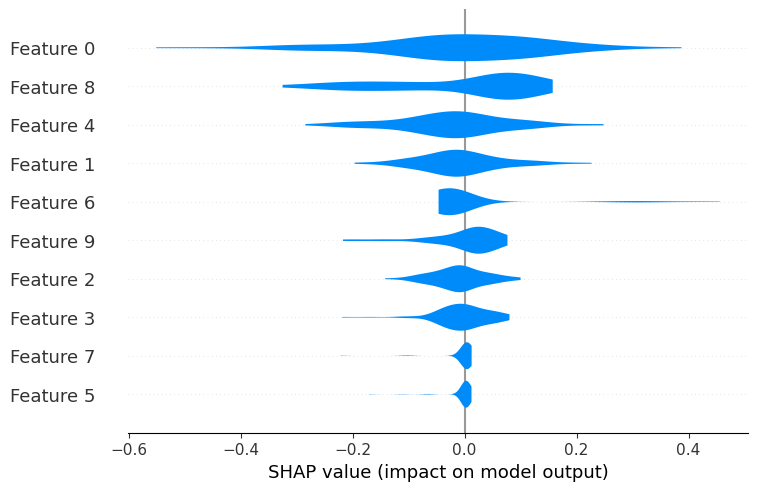

In [ ]:
# Generate a violin plot
# shap.plots.violin(shap_values[1])